# Importando bibliotecas

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.integrate import odeint
import matplotlib.pyplot as pl
import scipy.io
import random
import csv

# Importando Arquivos

In [38]:
Dados = pd.read_csv ('dados/Dados_novos_BAHIA.csv')

Psi = scipy.io.loadmat('dados/Psi_Ba13set.mat')
# Pega a lista de itens referentes aos psi do arquivo .mat 
# no terceiro index do array Psi
Psi = list(Psi.values())[3]

latestPsi = Psi[-1]
for i in range(638):
    randomUncertanty = round(random.uniform(.01, .05), 4)
    uncertantyPsi =  latestPsi+randomUncertanty
    
    uncertantyPsi = np.array([uncertantyPsi])
    Psi = np.append(Psi, uncertantyPsi)

np.savetxt('psi.csv', Psi, delimiter=',')

# Definindo média móvel do PSI

In [39]:
npd = len(Psi)
Nfo = 8

Psif = [[0]]*npd

for k in range(1, npd):
    if (k-Nfo) < 0 :
        Psif[k] = 1/k*sum(Psi[0:k])
    else:
        Psif[k] = 1/Nfo*sum(Psi[k-Nfo:k])

Psif.pop(0)

[0]

# Separando dados

In [40]:
# casos_dados = Dados['Casos acumulados'].fillna(0)

# recuperados_dados = Dados['Recuperados'].fillna(0)

# mortos_dados = Dados['Mortos'].fillna(0)

# hospitalizados_dados = Dados['Hospitalizados'].fillna(0)

# uti_dados = Dados['UTI'].fillna(0)

# vacinados_dados = Dados['Vacinados'].fillna(0)

# novos_casos = np.diff(casos_dados)
# novos_mortos = np.diff(mortos_dados)

# inicio_da_vacinacao = 19

# novos_vacinados = np.diff(vacinados_dados)


# Dados antigos

In [41]:
Dados = scipy.io.loadmat('dados/dadosAntigos.mat')
Psi = scipy.io.loadmat('dados/Psi_Ba13set.mat')

Dados = list(Dados.values())[3]

# Separando dados antigos

In [42]:
casos_dados = Dados[:,0]
# casos_dados = np.repeat(casos_dados, 4)

recuperados_dados = Dados[:,6]
# recuperados_dados = np.repeat(recuperados_dados, 4)

mortos_dados = Dados[:,4]
# mortos_dados = np.repeat(mortos_dados, 4)

hospitalizados_dados = Dados[:,1]
# hospitalizados_dados = np.repeat(hospitalizados_dados, 4)

uti_dados = Dados[:,2]
# uti_dados = np.repeat(uti_dados, 4)

vacinados_dados = Dados[:,7]
# vacinados_dados = np.repeat(vacinados_dados, 4)

data_in = '06/03/2020'

novos_casos = np.diff(casos_dados)
# novos_casos = novos_casos.tolist()
# novos_casos = np.repeat(novos_casos, 4)

novos_mortos = np.diff(mortos_dados)
# novos_casos = novos_mortos.tolist()
# novos_casos = np.repeat(novos_mortos, 4)

inicio_da_vacinacao = 100

# Definindo condicoes iniciais

In [43]:
D0          = mortos_dados[0] # 9159
N0          = 14930634
R0          = 478198
H0          = hospitalizados_dados[0] # 477
HV0         = 0
U0          = uti_dados[0] # 737
UV0         = 0
V0          = vacinados_dados[0] # 0
Rv0         = 0
Is0         = casos_dados[0]-451240
Ia0         = Is0*0.9
Iav0        = 0
Isv0        = 0 
E0          = (518955-casos_dados[0])
Ev0         = 0
S0          = (14930634-Is0-Ia0-E0)
Nw0         = 0
NwV0        = 0


# Condições iniciais antigas
D0          = 0;
N0          = 14930634;
R0          = 0;
H0          = 0;
U0          = 0;
V0          = 1000/N0;  
Rv0         = 0; 
Is0         = 2.015439771376298e-06;
Ia0         = 1.8028646508967777e-06;
Iav0        = 1.8028646508967777e-06; 
Isv0        = 1.8028646508967777e-06; 
E0          = 1.7639153732952095e-06;
Ev0         = 1.7639153732952095e-06;
S0          = (1-Is0-Ia0-E0);
Nw0         = 0;
NwV0        = 0;


condicoes_iniciais = [S0,E0,V0,Ev0,Ia0,Is0,Iav0,Isv0,H0,HV0,U0,UV0,R0,Rv0,D0,Nw0,NwV0];

# Definindo modelo

In [44]:
def seiihurd(y, t):
    k = 1/4
    gamma_a = 1/3.5
    gamma_s = 1/4
    gamma_h = 0.18
    gamma_u = 0.13342706158133355
    mi_u = 0.4
    qsi = 0.53
    h = 0.06
    h_v = 0
    mi_h = 0.15
    ome_h = 0.14
    ome_u = 0.29
    delta = 0.31
    p = 0.2
    
    if t<20.178:
        beta=2.1317
    elif (t>=20.178-8) and (t < 72.94):
        beta=1.7645
    elif (t>=72.94) and (t < 148):
        beta=1.1281
    elif t > 250 and t < 450:
        beta = 1.895289960971258
    else:
        beta=1

    # beta_v = beta*0.5
    beta_v = 0
    
    if t<100: #inicio_da_vacinacao:
        delta_av = 0
        delta_sv = 0
        phi_e = 0
        k_v=0
        p_v = 0
        gamma_av = 0
        gamma_sv = 0
        gamma_vu=0
        qsi_v = 0 
        eps=0
        mi_vh=0
        mi_vu=0
        gamma_vh=0
        tau=0
    else:
        delta_av = 0.31
        delta_sv = 0.31
        phi_e = 0.8
        k_v=1/3
        p_v = 0.1
        gamma_av = 1/3.5
        gamma_sv = 1/4
        gamma_vu=0.26
        qsi_v = 0.99
        eps=0.7
        mi_vh=0.03
        mi_vu=0.25
        gamma_vh=0.08
        tau=(6.6976e-05)*1.1
 
    # tau=novos_vacinados[int(t)]
    # N=14930634
    N=1
    psi=Psif[int(t)]

    S=y[0]
    E=y[1]
    Sv=y[2]
    Ev=y[3]
    Ia=y[4]
    Is=y[5]
    Iav=y[6]
    Isv=y[7]
    H=y[8]
    Hv=y[9]
    U=y[10]
    Uv=y[11]
    R=y[12]
    Rv=y[13]
    D=y[14]
    Nw=y[15]
    NwV=y[16]

    dSdt = -(1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - tau/N
    dEdt = (1-psi)*beta*S*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k*E
    dSvdt = tau/N - (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - phi_e*eps*Sv
    dEvdt = (1-psi)*beta_v*Sv*(Is+delta*Ia+delta_av*Iav+delta_sv*Isv)/N - k_v*Ev
    dIadt = (1-p)*k*E - gamma_a*Ia
    dIsdt = p*k*E - gamma_s*Is
    dIavdt = (1-p_v)*k_v*Ev - gamma_av*Iav
    dIsvdt = p_v*k_v*Ev - gamma_sv*Isv
    dHdt = h*qsi*gamma_s*Is + (1-mi_u+ome_u*mi_u)*gamma_u*U - gamma_h*H
    dHvdt = h_v*qsi_v*gamma_sv*Isv + (1-mi_vu+ome_u*mi_vu)*gamma_vu*Uv - gamma_vu*Hv
    dUdt = h*(1-qsi)*gamma_s*Is + ome_h*gamma_h*H - gamma_u*U
    dUvdt = h_v*(1-qsi_v)*gamma_sv*Isv + ome_h*gamma_h*Hv - gamma_u*Uv
    dRdt = gamma_a*Ia + (1-h)*gamma_s*Is + (1-mi_h)*(1-ome_h)*gamma_h*H - phi_e*eps*Sv
    dRvdt = gamma_av*Iav + (1-h)*gamma_sv*Isv + (1-mi_vh)*(1-ome_h)*(gamma_vh*Hv)
    dDdt = (1-ome_h)*(mi_h*gamma_h*H +mi_vh*gamma_vh*Hv) + (1-ome_h)*(mi_u*gamma_u*U+mi_vu*gamma_vu*Uv)
    dNwdt = p*k*E + p_v*k_v*Ev
    dNwVdt = tau/N
    
    return [dSdt, dEdt, dSvdt, dEvdt, dIadt, dIsdt, dIavdt, dIsvdt, dHdt, dHvdt, dUdt, dUvdt, dRdt, dRvdt, dDdt, dNwdt, dNwVdt]



# Chamando modelo

In [45]:
tempo = list(range(0, len(Psif[:636])))
resultados = odeint(seiihurd, condicoes_iniciais, tempo)
resultados_modelo = resultados

Sm = N0*resultados[:,0]
Em = N0*resultados[:,1]
Svm = N0*resultados[:,2]
Evm = N0*resultados[:,3]
Iam = N0*resultados[:,4]
Ism = N0*resultados[:,5]
Iavm = N0*resultados[:,6]
Isvm = N0*resultados[:,7]
Hm = N0*resultados[:,8]
Hvm = N0*resultados[:,9]
Um = N0*resultados[:,10]
Uvm = N0*resultados[:,11]
Rm = N0*resultados[:,12]
Rvm = N0*resultados[:,13]
Dm = N0*resultados[:,14]
Nwm = N0*resultados[:,15]
NwVm = N0*resultados[:,16]

# Plotando graficos

### Hospitalizados

831


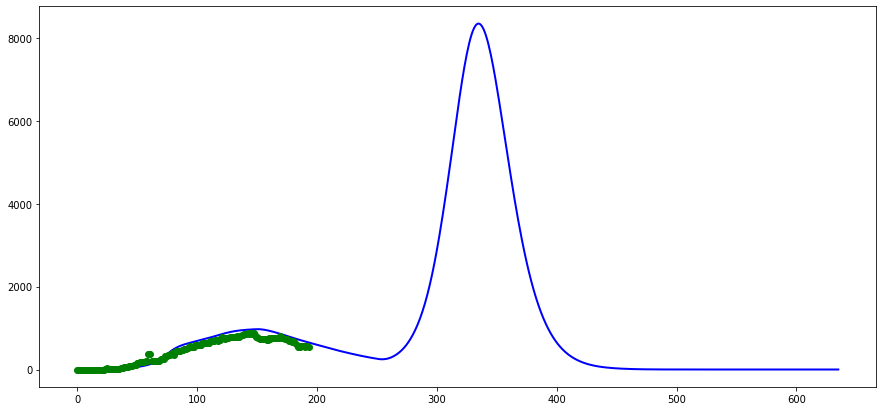

In [46]:
ts1=np.arange(len(Psif[:636]))
fig, ax = pl.subplots(figsize=(15,7))
print(len(Psif))
ax.plot(ts1,  Hm, color='b',zorder=1, linewidth=2)
ax.scatter(ts1[:len(hospitalizados_dados)], hospitalizados_dados, color='g',zorder=1, linewidth=1)
ax.autoscale()
pl.show()

### UTI

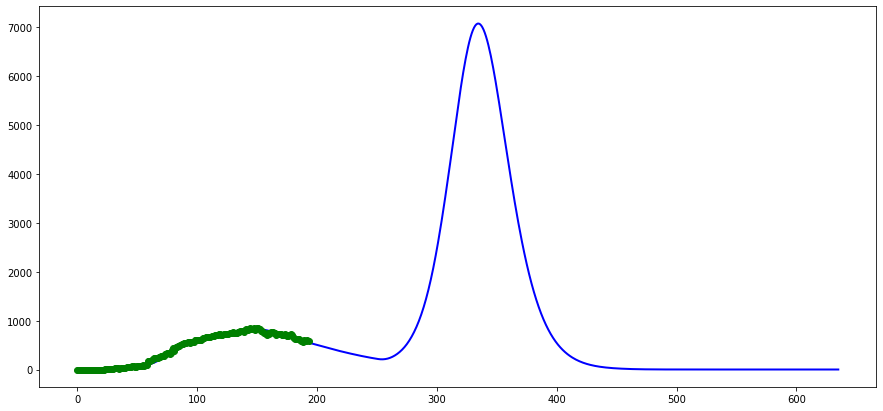

In [47]:
ts1=np.arange(len(Psif[:636]))
fig, ax = pl.subplots(figsize=(15,7))

ax.plot(ts1,  Um, color='b',zorder=1, linewidth=2)
ax.scatter(ts1[:len(uti_dados)], uti_dados, color='g',zorder=1, linewidth=1)
ax.autoscale()
pl.show()

### Casos Acumulados

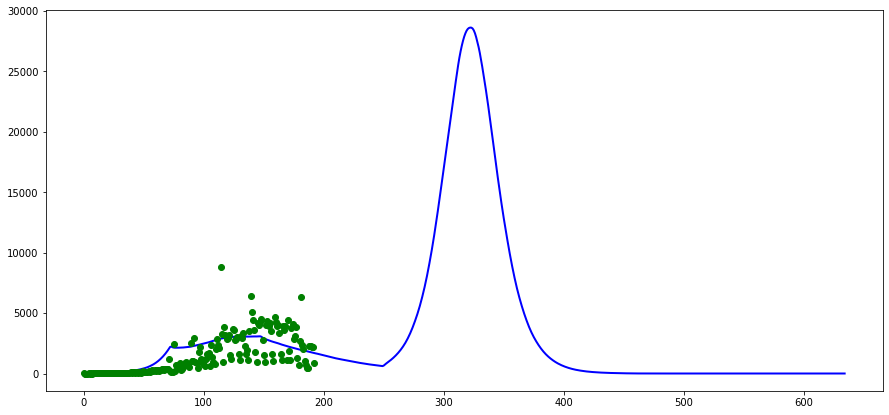

In [48]:
ts1=np.arange(len(Psif[:636])-1)
fig, ax = pl.subplots(figsize=(15,7))

Nwm_i = np.diff(Nwm)
Nwm_i_dados = np.diff(casos_dados)

ax.plot(ts1,  Nwm_i, color='b',zorder=1, linewidth=2)
ax.scatter(ts1[:len(Nwm_i_dados)], Nwm_i_dados[:len(Psif)-2], color='g',zorder=1, linewidth=1)
ax.autoscale()
pl.show()

### Mortos

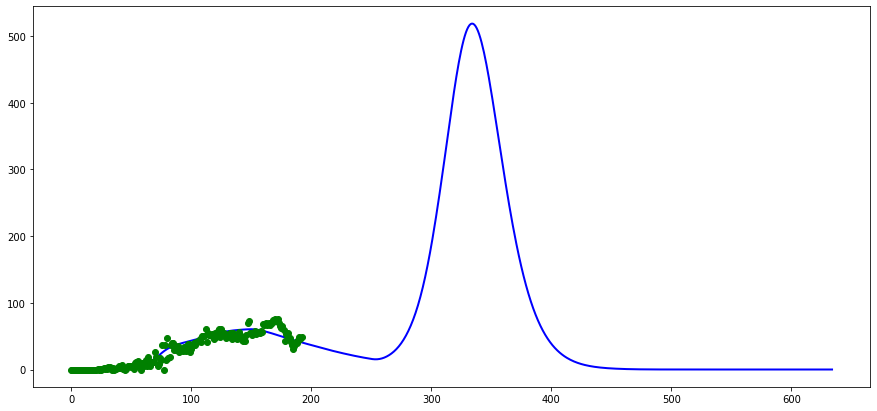

In [49]:
ts1=np.arange(len(Psif[:636])-1)
fig, ax = pl.subplots(figsize=(15,7))

Nwm_d = np.diff(Dm)
Nwm_d_dados = np.diff(mortos_dados)

ax.plot(ts1,  Nwm_d, color='b',zorder=1, linewidth=2)
ax.scatter(ts1[:len(Nwm_d_dados)], Nwm_d_dados[:len(Psif)-2], color='g',zorder=1, linewidth=1)
ax.autoscale()
pl.show()

### Vacinados

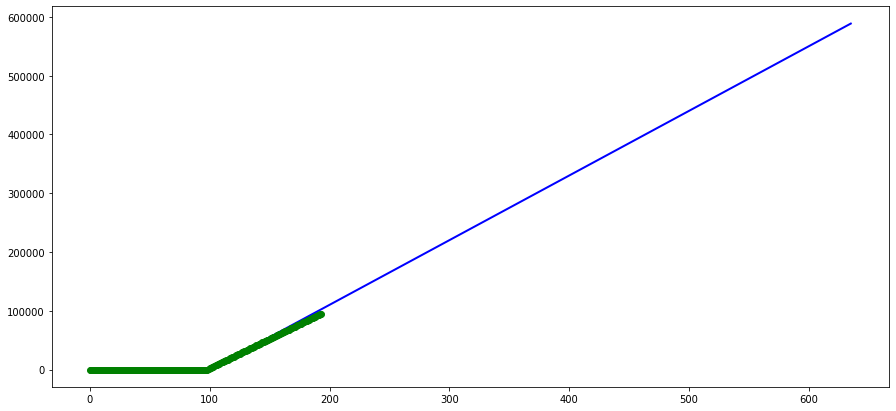

In [50]:
ts1=np.arange(len(Psif[:636]))
fig, ax = pl.subplots(figsize=(15,7))

ax.plot(ts1,  NwVm, color='b',zorder=1, linewidth=2)
ax.scatter(ts1[:len(vacinados_dados)], vacinados_dados[:len(Psif)-1], color='g',zorder=1, linewidth=1)
ax.autoscale()
pl.show()

# Plotando dados completos

## Importando dados

In [51]:
Dados = pd.read_csv ('dados/estado.csv')

casos_dados = Dados['cases'].fillna(0)
mortes_dados = Dados['deaths'].fillna(0)

## Plotando casos

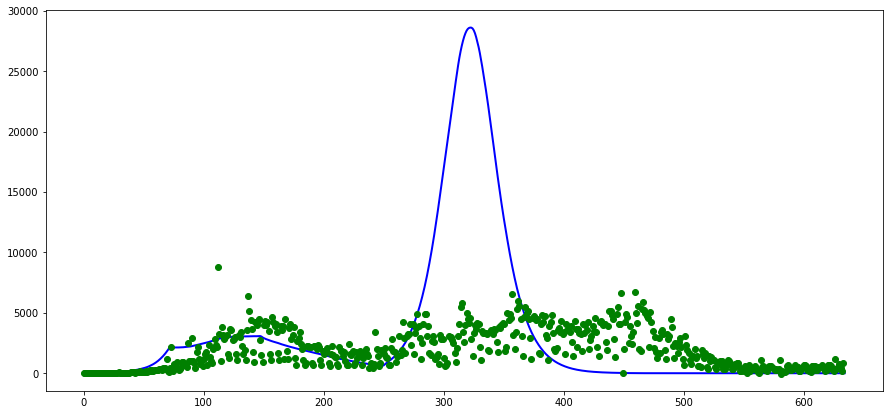

In [52]:
ts1=np.arange(len(Psif[:636])-1)
fig, ax = pl.subplots(figsize=(15,7))

Nwm_i = np.diff(Nwm)
Nwm_i_dados = np.diff(casos_dados)

ax.plot(ts1,  Nwm_i, color='b',zorder=1, linewidth=2)
ax.scatter(ts1[:len(Nwm_i_dados)], Nwm_i_dados[:len(Psif)-2], color='g',zorder=1, linewidth=1)
ax.autoscale()
pl.show()

## Plotando mortos

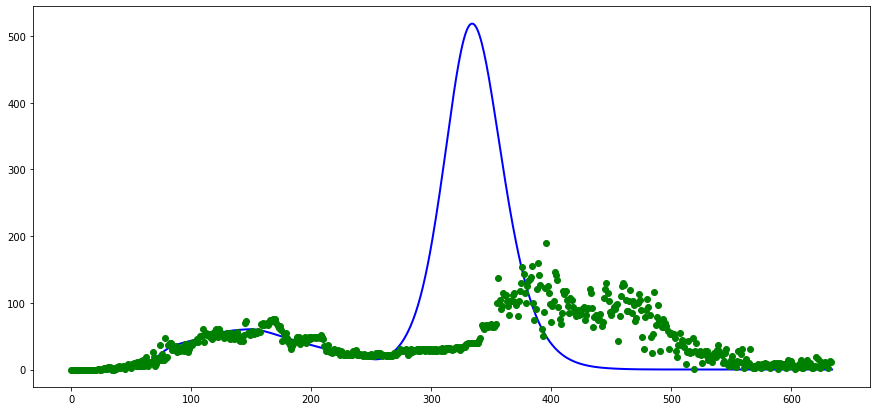

In [53]:
ts1=np.arange(len(Psif[:636])-1)
fig, ax = pl.subplots(figsize=(15,7))

Nwm_d = np.diff(Dm)
Nwm_d_dados = np.diff(mortes_dados)

ax.plot(ts1,  Nwm_d, color='b',zorder=1, linewidth=2)
ax.scatter(ts1[:len(Nwm_d_dados)], Nwm_d_dados[:len(Psif)-2], color='g',zorder=1, linewidth=1)
ax.autoscale()
pl.show()

## Plotando o psi

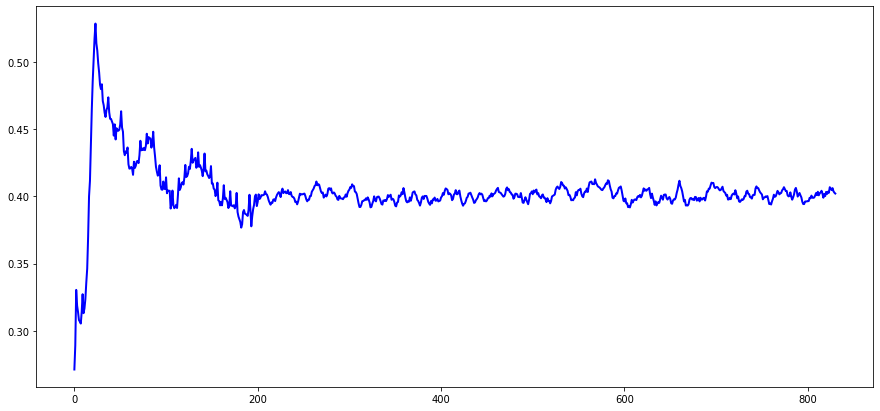

In [54]:
ts1=np.arange(len(Psif))
fig, ax = pl.subplots(figsize=(15,7))

ax.plot(ts1,  Psif, color='b',zorder=1, linewidth=2)
pl.show()